# Chapter 4 exercise implementation
Much help from:
https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/04.%20Sample%20Weights.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

## Code snippets

### Estimating uniqueness of a label [4.1]

In [2]:
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

In [161]:
# def mpNumCoEvents(closeIdx,t1,molecule):
#     '''
#     Compute the number of concurrent events per bar.
#     +molecule[0] is the date of the first event on which the weight will be computed
#     +molecule[-1] is the date of the last event on which the weight will be computed
    
#     Any event that starts before t1[modelcule].max() impacts the count.
#     '''
#     #1) find events that span the period [molecule[0],molecule[-1]]
#     t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
#     t1=t1[t1.index>=molecule[0]] # events that end at or after molecule[0]
#     t1=t1.loc[:t1.reindex(events.index).index[-1]] # events that start at or before t1[molecule].max()
#     #2) count events spanning a bar
#     iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.index[-1]]))
#     count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
#     for tIn,tOut in t1.iteritems(): 
#         #Basically, tIn and tOut is the range of a 'buy' to first touch of barrier, and for each of those ranges +1
#         count.loc[tIn:tOut]+=1.
#     return count.loc[molecule[0]:t1[molecule].max()]

### Estimating the average uniqueness of a label [4.2]

In [3]:
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule, dtype=float)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

### Build Indicator Matrix [4.3]

In [5]:
def getIndMatrix(barIx,t1):
    # Get Indicator matrix
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

### Compute average uniqueness [4.4]

In [6]:
def getAvgUniqueness(indM):
    # Average uniqueness from indicator matrix
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

### return sample from sequential bootstrap [4.5]

In [94]:
def seqBootstrap(indM,sLength=None):
    # Generate a sample via sequential bootstrap
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series(dtype=float)
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
        print(f"len(phi) is {len(phi)} which is < than sLength {sLength}")
    return phi

### SNIPPET 4.7 GENERATING A RANDOM T1 SERIES

### Determination of sample weight by absolute return attribution [4.10]¶

In [8]:
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule, dtype=float)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

### Implementation of Time-Decay Factors [4.11]

In [9]:
def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print(const,slope)
    return clfW

### Example of Sequential Bootstrap [4.6]

In [10]:
def main():
    np.random.seed(12121) # fix seed as results are unstable
    t1=pd.Series([2,3,5],index=[0,2,4]) # t0,t1 for each feature obs
    barIx=range(t1.max()+1) # index of bars
    indM=snp.getIndMatrix(barIx,t1)
    phi_random=np.random.choice(indM.columns,size=indM.shape[1])
    print(phi_random)
    print(f'Standard uniqueness: {snp.getAvgUniqueness(indM[phi_random]).mean():.4f}')
    phi_seq=snp.seqBootstrap(indM)
    print(phi_seq)
    print(f'Sequential uniqueness: {snp.getAvgUniqueness(indM[phi_seq]).mean():.4f}')
    
# main()

# Exercise

## 1. In Chapter 3, we denoted as t1 a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the getEvents function.

### a) Compute a t1 series on dollar bars derived from E-mini S&P 500 futures tick data.
(Or in this case btc)

In [11]:
t1 = pd.to_datetime(pd.read_csv("../data/t1.csv", index_col=0, parse_dates=True, squeeze=True))

In [12]:
t1

2021-04-23 07:31:43.163   2021-04-24 07:31:46.976
2021-04-23 08:09:56.981   2021-04-24 08:10:03.818
2021-04-23 08:31:35.814   2021-04-24 08:31:40.279
2021-04-23 09:40:37.273   2021-04-24 09:40:40.242
2021-04-23 10:06:50.048   2021-04-24 10:06:52.614
                                    ...          
2021-06-18 03:49:00.094   2021-06-19 03:49:01.115
2021-06-18 10:02:30.206   2021-06-19 10:02:31.439
2021-06-18 10:57:56.538   2021-06-19 10:58:02.300
2021-06-18 13:13:03.131   2021-06-19 13:13:09.648
2021-06-18 14:16:19.376   2021-06-19 14:16:39.233
Name: time, Length: 594, dtype: datetime64[ns]

### b) Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time.

In [13]:
events = pd.read_csv("../data/events.csv", index_col=0, parse_dates=[0, 1])
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)

In [14]:
events

,t1,trgt,side
2021-04-23 07:31:43.163,2021-04-24 07:31:46.976,0.020325,NaN
2021-04-23 08:09:56.981,2021-04-24 08:10:03.818,0.020990,NaN
2021-04-23 08:31:35.814,2021-04-24 08:31:40.279,0.020496,NaN
2021-04-23 09:40:37.273,2021-04-24 09:40:40.242,0.019150,NaN
2021-04-23 10:06:50.048,2021-04-24 10:06:52.614,0.018793,NaN
...,...,...,...
2021-06-19 04:32:03.276,NaT,0.016546,NaN
2021-06-19 06:30:57.226,NaT,0.015636,NaN
2021-06-19 12:07:09.748,NaT,0.013532,NaN
2021-06-19 12:48:14.298,NaT,0.013560,NaN


In [15]:
numCoEvents = mp_pandas_obj(mpNumCoEvents,('molecule',events.index),                         
                              1,closeIdx=df.index,t1=events['t1'])

In [16]:
numCoEvents

2021-04-23 07:31:43.163     1.0
2021-04-23 07:31:44.212     1.0
2021-04-23 07:31:45.347     1.0
2021-04-23 07:31:47.652     1.0
2021-04-23 07:31:50.047     1.0
                           ... 
2021-06-19 16:27:04.502    11.0
2021-06-19 16:27:20.667    11.0
2021-06-19 16:27:26.627    11.0
2021-06-19 16:27:44.405    11.0
2021-06-19 16:27:48.270    11.0
Length: 999315, dtype: float64

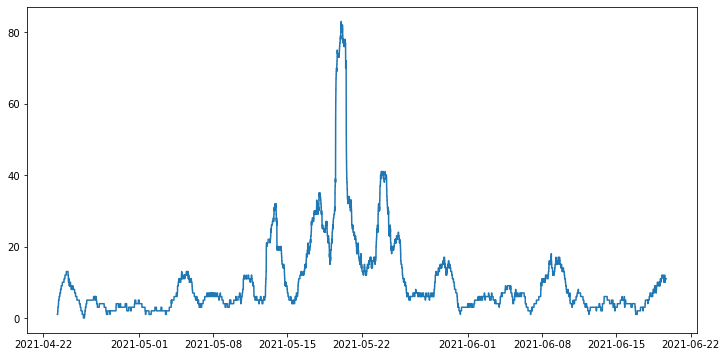

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(numCoEvents)

In [18]:
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]

In [19]:
numCoEvents = numCoEvents.reindex(df.index).fillna(0)

In [20]:
numCoEvents

time
2017-08-17 04:21:13.356     0.0
2017-08-17 04:29:19.766     0.0
2017-08-17 04:33:00.057     0.0
2017-08-17 04:39:32.027     0.0
2017-08-17 04:43:05.191     0.0
                           ... 
2021-06-19 16:27:04.502    11.0
2021-06-19 16:27:20.667    11.0
2021-06-19 16:27:26.627    11.0
2021-06-19 16:27:44.405    11.0
2021-06-19 16:27:48.270    11.0
Length: 11798850, dtype: float64

In [21]:
out=pd.DataFrame()
out['tW'] = mp_pandas_obj(mpSampleTW,('molecule',events.index),
                            1,t1=events['t1'],numCoEvents=numCoEvents)
## example ##
out['w']=mp_pandas_obj(mpSampleW,('molecule',events.index),1,
                         t1=events['t1'],numCoEvents=numCoEvents,close=df.close)
out['w']*=out.shape[0]/out['w'].sum()

out

,tW,w
2021-04-23 07:31:43.163,0.231878,1.226889
2021-04-23 08:09:56.981,0.156455,3.080714
2021-04-23 08:31:35.814,0.141238,1.225136
2021-04-23 09:40:37.273,0.122657,1.981628
2021-04-23 10:06:50.048,0.118390,0.726506
...,...,...
2021-06-19 04:32:03.276,0.089894,0.256731
2021-06-19 06:30:57.226,0.089685,0.136556
2021-06-19 12:07:09.748,0.090909,0.165209
2021-06-19 12:48:14.298,0.090909,0.078581


### c) Plot the time series of the number of concurrent labels on the primary axis, and the time series of exponentially weighted moving standard deviation of returns on the secondary axis.

In [23]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

In [25]:
coEvents_std = (
    pd.DataFrame()
    .assign(
        numCoEvents = numCoEvents.reset_index(drop=True),
        std = returns(df.close).ewm(50).std().reset_index(drop=True))
)
coEvents_std

,numCoEvents,std
0,0.0,NaN
1,0.0,0.000109
2,0.0,0.004272
3,0.0,0.003729
4,0.0,0.003215
...,...,...
11798845,11.0,0.000401
11798846,11.0,0.000398
11798847,11.0,0.000403
11798848,11.0,0.000400


<AxesSubplot:label='b9437145-b295-4163-8faf-739e9d20239d'>

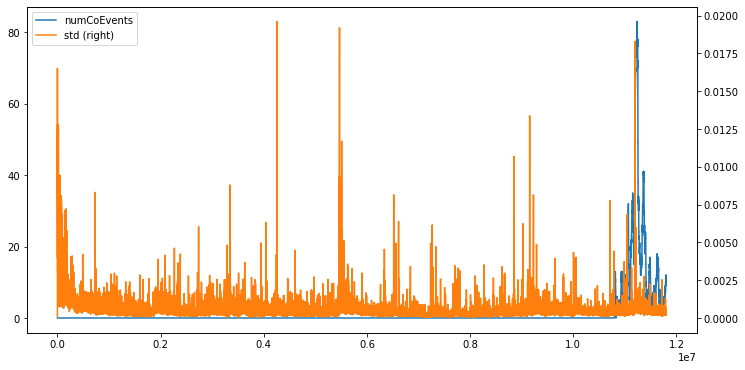

In [26]:
fig, ax = plt.subplots(figsize=(12,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)

### d) Produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving standard deviation of returns (y-axis). Can you appreciate a relationship?

In [28]:
vol = pd.read_csv("../data/vol.csv", index_col=0, parse_dates=True, squeeze=True)

In [31]:
cl = mp_pandas_obj(mpNumCoEvents,('molecule',events.index),                         
                              1,closeIdx=df.index,t1=events['t1'])

In [38]:
vol = vol.reindex(cl.index)
vol

2021-04-23 07:31:43.163    0.020325
2021-04-23 07:31:44.212    0.020325
2021-04-23 07:31:45.347    0.020324
2021-04-23 07:31:47.652    0.020324
2021-04-23 07:31:50.047    0.020324
                             ...   
2021-06-19 16:27:04.502    0.012078
2021-06-19 16:27:20.667    0.012077
2021-06-19 16:27:26.627    0.012076
2021-06-19 16:27:44.405    0.012075
2021-06-19 16:27:48.270    0.012074
Name: close, Length: 999315, dtype: float64

In [34]:
cl

2021-04-23 07:31:43.163     1.0
2021-04-23 07:31:44.212     1.0
2021-04-23 07:31:45.347     1.0
2021-04-23 07:31:47.652     1.0
2021-04-23 07:31:50.047     1.0
                           ... 
2021-06-19 16:27:04.502    11.0
2021-06-19 16:27:20.667    11.0
2021-06-19 16:27:26.627    11.0
2021-06-19 16:27:44.405    11.0
2021-06-19 16:27:48.270    11.0
Length: 999315, dtype: float64

Text(0, 0.5, 'exponentially weighted moving standard deviation of returns')

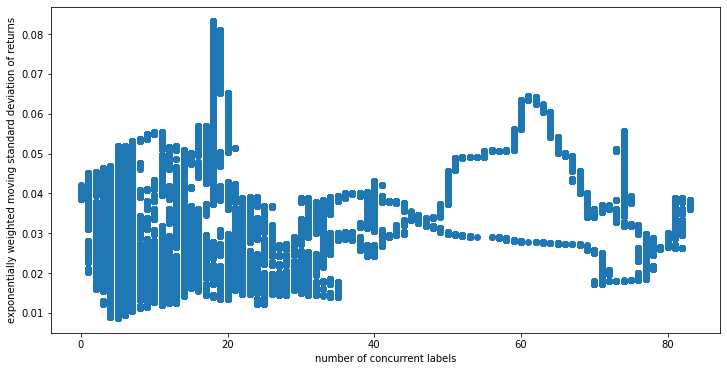

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(cl, vol)
ax.set_xlabel("number of concurrent labels")
ax.set_ylabel("exponentially weighted moving standard deviation of returns")

## Sequential bootstrap
Want high average uniqueness

In [90]:
t1 = pd.to_datetime(pd.read_csv("../data/t1.csv", index_col=0, parse_dates=True, squeeze=True))
from datetime import timedelta

In [91]:
df.loc[t1.index[0]:t1.index[-1]].index

DatetimeIndex(['2021-04-23 07:31:43.163000', '2021-04-23 07:31:44.212000',
               '2021-04-23 07:31:45.347000', '2021-04-23 07:31:47.652000',
               '2021-04-23 07:31:50.047000', '2021-04-23 07:31:50.916000',
               '2021-04-23 07:31:52.471000', '2021-04-23 07:31:54.657000',
               '2021-04-23 07:31:58.422000', '2021-04-23 07:31:58.865000',
               ...
               '2021-06-18 14:16:06.809000', '2021-06-18 14:16:07.065000',
               '2021-06-18 14:16:08.801000', '2021-06-18 14:16:10.773000',
               '2021-06-18 14:16:12.665000', '2021-06-18 14:16:13.107000',
               '2021-06-18 14:16:15.545000', '2021-06-18 14:16:18.872000',
               '2021-06-18 14:16:19.118000', '2021-06-18 14:16:19.376000'],
              dtype='datetime64[ns]', name='time', length=982942, freq=None)

In [95]:
# def main(t1):
#     np.random.seed(12121) # fix seed as results are unstable
# t1=pd.Series([2,3,5,7,23,23,23,25,26,30,30],index=[0,2,4,6,10,12,15,20,21,22,24]) # t0,t1 for each feature obs
# barIx=range(t1.max()+1) # index of bars
# barIx=df.loc[t1.index[0]:t1.index[-1]].index # index of bars
barIx=t1.index # index of bars


indM=getIndMatrix(barIx,t1)
phi_random=np.random.choice(indM.columns,size=indM.shape[1])
# print(phi_random)
print(f'Standard uniqueness: {getAvgUniqueness(indM[phi_random]).mean():.4f}')
phi_seq=seqBootstrap(indM)
print(phi_seq)
print(f'Sequential uniqueness: {getAvgUniqueness(indM[phi_seq]).mean():.4f}')
    
# main(t1)

Standard uniqueness: 0.0828
len(phi) is 1 which is < than sLength 594
len(phi) is 2 which is < than sLength 594
len(phi) is 3 which is < than sLength 594
len(phi) is 4 which is < than sLength 594
len(phi) is 5 which is < than sLength 594
len(phi) is 6 which is < than sLength 594
len(phi) is 7 which is < than sLength 594
len(phi) is 8 which is < than sLength 594
len(phi) is 9 which is < than sLength 594
len(phi) is 10 which is < than sLength 594
len(phi) is 11 which is < than sLength 594
len(phi) is 12 which is < than sLength 594
len(phi) is 13 which is < than sLength 594
len(phi) is 14 which is < than sLength 594
len(phi) is 15 which is < than sLength 594
len(phi) is 16 which is < than sLength 594
len(phi) is 17 which is < than sLength 594
len(phi) is 18 which is < than sLength 594
len(phi) is 19 which is < than sLength 594
len(phi) is 20 which is < than sLength 594
len(phi) is 21 which is < than sLength 594
len(phi) is 22 which is < than sLength 594
len(phi) is 23 which is < than sLen

In [96]:
seq = list(map(lambda x: t1.index[x], phi_seq))

In [98]:
new_t1 = t1.reindex(seq)
new_t1.head(), len(new_t1), len(t1)

(2021-06-09 02:47:30.543   2021-06-10 02:47:40.441
 2021-05-16 01:12:20.174   2021-05-17 01:12:21.380
 2021-06-18 10:02:30.206   2021-06-19 10:02:31.439
 2021-05-24 16:41:37.827   2021-05-25 16:41:47.573
 2021-05-19 13:15:51.289   2021-05-20 13:15:56.797
 Name: time, dtype: datetime64[ns],
 594,
 594)

In [99]:
# new_t1.to_csv("../data/seq_bootstrap.csv")

In [88]:
indM

,0,1,2,3,4,5,6,7,8,9,...,584,585,586,587,588,589,590,591,592,593
time,,,,,,,,,,,,,,,,,,,,,
2021-04-23 07:31:43.163,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-23 07:31:44.212,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-23 07:31:45.347,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-23 07:31:47.652,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-23 07:31:50.047,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-18 14:16:13.107,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
2021-06-18 14:16:15.545,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
2021-06-18 14:16:18.872,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


## Time decay

In [ ]:
def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print(const,slope)
    return clfW

def getExTimeDecay(tW,clfLastW=1.,exponent=1):
    # apply exponential decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=((1.-clfLastW)/clfW.iloc[-1])**exponent
    else: slope=(1./((clfLastW+1)*clfW.iloc[-1]))**exponent
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print(round(const,4), round(slope,4))
    return clfW

In [ ]:
f,ax=plt.subplots(2,figsize=(10,7))
fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']
for lstW, l in zip(fs,ls):
    decayFactor = getExTimeDecay(out['tW'].dropna(), 
                                 clfLastW=lstW,
                                 exponent=0.75) # experiment by changing exponent
    ((out['w'].dropna()*decayFactor).reset_index(drop=True)
     .plot(ax=ax[0],alpha=0.5))
    s = (pd.Series(1,index=out['w'].dropna().index)*decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))